# Amazon Mechanical Turk

The role of this script is to generate the data in a format that we can use to label on Mechanical Turk

1. Generate the next batch
2. Read the batch and write it to MongoDB

In [1]:
from data.dao import DataAccess, LabelGetter
from data.turk import TurkResults2Label

import pandas as pd
import datetime
import re
import pickle
import numpy

%matplotlib inline

Getting the data from DataAccess is so easy!

In [2]:
%%time

X = DataAccess.get_not_labeled().sort("random_number")
X.head(10)

CPU times: user 1.37 s, sys: 1.4 s, total: 2.76 s
Wall time: 11.4 s


In [3]:
X_filter = X[X.control != 1]
X_filter.head()

,control,predict,random_number,text
_id,,,,
556e8debd6dfbb3061976b0e,NaN,0.215714,0.004196,My #TeenChoice nominee for #ChoiceMaleWebStar ...
5575d384d6dfbb66f9dac606,NaN,0.194029,0.004235,#TweetMyJobs #Accounting #Job alert: Senior Ac...
5572131ed6dfbb33bf90487d,NaN,0.338928,0.004239,"Never imagined myself saying this 3 years ago,..."
5572b598d6dfbb719b60fb40,NaN,0.411088,0.004250,Who made me drink &amp; why?
557849c1d6dfbb56c0b31675,NaN,0.258357,0.004261,".@BilldeBlasio Opposes Linking Tax Credit, Ren..."


In [4]:
X_control = X[X.control == 1]
X_control.head()

,control,predict,random_number,text
_id,,,,
5584b355d6dfbb636c07fba4,1,NaN,NaN,Now that's a malty hop punch. Great bitterness...
558ded7dd6dfbb1d49557f3f,1,NaN,NaN,5star Friday continues after a delay.... - Dri...
557a3d92d6dfbb59f52789b3,1,NaN,NaN,"Late check-in, perfect hot as balls day crisp ..."
556ba263d6dfbb336fb8c141,1,NaN,NaN,Drinking a Rams Head IPA by @FoDoBrewing @ Bar...
556ba2c8d6dfbb336fb8c582,1,NaN,NaN,Drinking a Summerweisse by @BottleLogicBrew at...


In [5]:
len(X_filter)

81122

In [6]:
len(X_control)

483

# Preprocessing

In [7]:
from __private import fs
from classification.dao import ClassifierAccess

In [8]:
fs.list()

['alcohol|accuracy:0.8143360752056404|f1:0.8192219679633866|type:LogisticRegression',
 'alcohol|accuracy:0.8401880141010576|f1:0.8498896247240618|type:SVC',
 'alcohol|accuracy:0.8425381903642774|f1:0.8562231759656651|type:RandomForestClassifier',
 'first_person_label|accuracy:0.5637860082304527|f1:0.5574430033343769|type:SVC',
 'first_person_label|accuracy:0.5637860082304527|f1:0.5643693591852614|type:LogisticRegression',
 'first_person|accuracy:0.6951871657754011|f1:0.8034482758620688|type:RandomForestClassifier',
 'first_person|accuracy:0.7005347593582888|f1:0.7751004016064257|type:LogisticRegression',
 'first_person|accuracy:0.7032085561497327|f1:0.8062827225130889|type:RandomForestClassifier',
 'first_person|accuracy:0.7112299465240641|f1:0.8021978021978021|type:SVC']

In [10]:
alcohol_classifier = ClassifierAccess.get_byfile(
    "alcohol|accuracy:0.8401880141010576|f1:0.8498896247240618|type:SVC"
)

firstperson_classifier = ClassifierAccess.get_byfile(
    "first_person|accuracy:0.7112299465240641|f1:0.8021978021978021|type:SVC"
)

In [11]:
X = X.sample(10000)

In [12]:
%%time

first_person = firstperson_classifier.predict_proba(X)[:,1]
alch_labels = alcohol_classifier.predict_proba(X)[:,1]

CPU times: user 1min 41s, sys: 2.32 s, total: 1min 43s
Wall time: 1min 43s


In [13]:
X["predicted_fp"] = first_person
X["predicted_alc"] = alch_labels

In [14]:
X["score"] = (X.predicted_alc * X.predicted_fp)

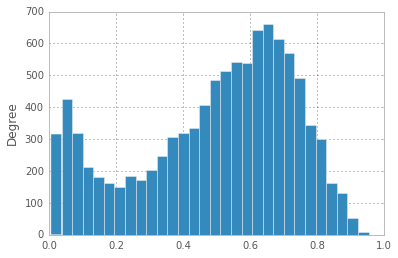

In [15]:
X.score.plot(kind="hist", bins=30)

In [16]:
X.random_number = X.text.apply(hash)

In [17]:
len(X)

10000

# Generating...

In [18]:
date = str(datetime.date.today())
candidate = X.sort("random_number").head(5000)
key = candidate.random_number.sum()

In [19]:
candidate["text"] = candidate.text.str.encode("utf-8")

In [20]:
candidate[["text", "random_number"]].to_csv(
    "../amt/c_amt|{}|{}.csv".format(date, key),
)

In [21]:
%%bash

ls ../amt/

Batch_2055156_batch_results.csv
Batch_2064123_batch_results.csv
Batch_2064125_batch_results.csv
Batch_2101169_batch_results.csv
Batch_2164917_batch_results.csv
Batch_2166655_batch_results.csv
Batch_2248153_batch_results.csv
amt_2015-08-13_4952308500878643456.csv
amt_2015-08-17_2546340314496401664.csv
amt_2015-08-20_8806137010034599936.csv
amt_2015-09-10_6072541214091395328.csv
amt_2015-09-24_-7976654553505407232.csv
amt|2015-09-10|6072541214091395328.csv
amt|2015-09-24|-7976654553505407232.csv
amt|2015-11-16|-6308615403510686754.csv
amt|2015-11-16|-81244987503678735.csv
amt|2015-11-16|287544318312245760.csv
c_amt_2015-11-16_-6269207037782773504.csv
c_amt_2015-11-16_7954396760112903981.csv
c_amt_2016-01-21_-8087639176019565329_2.csv
c_amt_2016-01-21_5520759830824576334.csv
c_amt_2016-01-29_7647127386955943697_2000.csv
c_amt_2016-01-30_-7432510530338082686.txt
c_amt_2016-01-31_0.1315425978524588_rest_of_control.csv
c_amt_2016-02-02_-4030591870299663666.csv
c_amt_2016-02-02_nan.csv
c_amt|

In [23]:
%%bash

open .. 

# Parsing to Label

#### New Labels

Straight from Amazon Mechanical Turk

In [42]:
df = pd.DataFrame.from_csv("/Users/JasonLiu/Downloads/Batch_2260366_batch_results.csv")
df = pd.DataFrame.from_csv("/Users/JasonLiu/Downloads/Batch_2253428_batch_results.csv")

In [43]:
df.Worker.value_counts().head(10)

A2AFTOA85C1FM9    677
A1T79J0XQXDDGC    562
A31O5XYX80XD21    291
A3F0M2W5XC5S62    279
A771BLWJLMWYY     278
ADJ9I7ZBFYFH7     213
A22634OVAX2IVC    159
A22VLXXVIEJSD1    110
A2QQY4S73JO639     90
A2J65ZHAJQDKAC     59
dtype: int64

In [50]:
df[df.Worker != "A1T79J0XQXDDGC"][["text", "Answer"]]

,text,Answer
HITID,,
3IV1AEQ4DRXOOV3FDDTNBU5QT998JL,b'I want the beach &amp; a fruity drink in my ...,First Person - Alcohol::Looking to drink
39WSF6KUV25JY7436T7SB0IY36HOEJ,"b""But maybe I'm too drunk to be tweeting my li...",First Person - Alcohol::Heavy Drinking
33NKDW9FFX2RVIYHBTOT4P9OUY8XC3,"b""Some drunk lady tried to suck on my neck an...",Alcohol Related::Discussion
3ZQX1VYFTDP2P6UCTQLSJQMCS3JO8K,b'thank god for wine and Wayward Pines',Alcohol Related::Discussion
3ZVPAMTJWNNKFYSA4GEK5Y8FR9GRGC,b'drink a beer // luke bryan',Alcohol Related::Discussion
3Q7TKIAPOTU60GN6X6GGD1WJ8PBDLY,b'Told myself I was going to the gym today.. B...,First Person - Alcohol::Looking to drink
3URJ6VVYUP71657AHNVF2E67QHNO4D,"b""too late 4 food porn.. y'all must be drunk""",Alcohol Related::Discussion
3ABAOCJ4R8OKV79W24NFDDI7R9QQMI,b'3 hours left till #TGIF drinking starts. WIL...,Not Alcohol Related
3W3RSPVVGSBSHIYSJ165N107UP6LUG,"b""I got dressed so drunk so I look like shit b...",First Person - Alcohol::Heavy Drinking


In [48]:
df = df[df.Worker != "A2AFTOA85C1FM9"]

In [33]:
df = df[df.Worker != "A2AFTOA85C1FM9"]
df = df[df.Answer != "Alcohol Related"]

In [34]:
len(df)

4999

In [38]:
df = df.set_index("_id")

In [39]:
df.head()

,text,random_number,Worker,Answer,Date
_id,,,,,
558df786d6dfbb2b5aadff61,"b'21 to drink, 18 to sleep over'",-3983732479117161297,A3F0M2W5XC5S62,Alcohol Related::Discussion,2016-02-07 23:05:41 UTC
55851d3ed6dfbb7f571917b7,b'Drunk in bed :)',-5220278192394077022,A3F0M2W5XC5S62,First Person - Alcohol::Heavy Drinking,2016-02-07 23:06:10 UTC
55746af4d6dfbb3bdb427042,"b""The bday boi and girl getting it in. @ RIC'S...",-7662040086887814805,A3F0M2W5XC5S62,First Person - Alcohol::Casual Drinking,2016-02-07 23:06:01 UTC
558dee13d6dfbb1d495585d1,b'Drinking an 60 Minute IPA by @dogfishbeer @ ...,-7050211665376073579,A3F0M2W5XC5S62,First Person - Alcohol::Casual Drinking,2016-02-07 23:05:51 UTC
5581ece5d6dfbb1537c09c08,b'My friend just got dumped-which sucks for he...,-4939467451569448549,A230VUDYOCRZ4N,Alcohol Related::Discussion,2016-02-07 23:06:14 UTC


#### Writing Labels using TurkResults2Label

In [41]:
%%time
DataAccess.write_labels(df.Answer.apply(TurkResults2Label.parse_to_labels))

CPU times: user 5.77 s, sys: 2.98 s, total: 8.76 s
Wall time: 8min 54s
